# v4

In [11]:
import numpy as np
import torch
from pathlib import Path

from configs import params_v4
from data_textart import (
    TextArtDataset,
    TextArtBatchCollate,
    TextBatchCollate,
)
from model import GradTTS
from torch.utils.data import DataLoader

from paths import DATA_DIR, CKPT_DIR, ENCODED_AUDIO_EN_DIR
from text.symbols import symbols

/home/anli/Desktop/art-tts/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
device='cpu'

add_blank = params_v4.add_blank
nsymbols = len(symbols) + 1 if add_blank else len(symbols)

model = GradTTS(
        nsymbols,
        params_v4.n_spks,
        None if params_v4.n_spks == 1 else params_v4.spk_embed_dim,
        params_v4.n_enc_channels,
        params_v4.filter_channels,
        params_v4.filter_channels_dp,
        params_v4.n_heads,
        params_v4.n_enc_layers,
        params_v4.enc_kernel,
        params_v4.enc_dropout,
        params_v4.window_size,
        params_v4.n_feats,
        params_v4.dec_dim,
        params_v4.beta_min,
        params_v4.beta_max,
        params_v4.pe_scale,
    ).to(device)

dataset_obj = TextArtDataset(
        params_v4.train_filelist_path,
        cmudict_path=params_v4.cmudict_path,
        data_root_dir=DATA_DIR,
        add_blank=params_v4.add_blank,
        reorder_feats=params_v4.reorder_feats,
        pitch_idx=params_v4.pitch_idx,
        log_normalize_loudness=params_v4.log_normalize_loudness,
        loudness_idx=params_v4.loudness_idx,
        load_coder=False,
        sparc_ckpt_path=params_v4.sparc_ckpt_path,
    )

reorder_feats = params_v4.reorder_feats
filepaths_list = dataset_obj.filepaths_list
collator = TextBatchCollate()

In [ ]:
truc = dataset_obj.get_pair(
    filepaths_list[0],
)

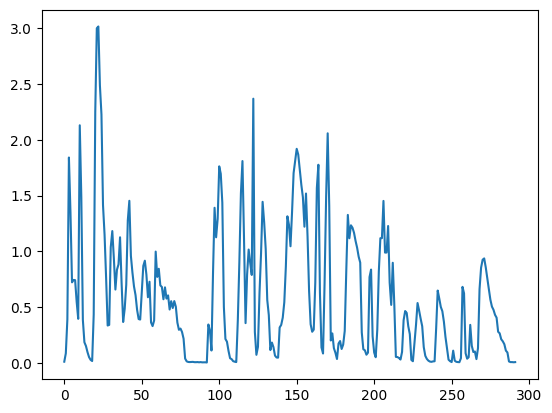

In [ ]:
import matplotlib.pyplot as plt

plt.plot(truc[1][13])

In [ ]:
L = []
for e in filepaths_list:
    truc = dataset_obj.get_pair(
        e,
    )
    L.append(min(truc[1][13]))

min(L)


tensor(0.0002)

# v2

In [ ]:
import numpy as np
import torch
from pathlib import Path

from configs import params_v2
from data_textmel import (
    TextMelDataset,
    TextMelBatchCollate,
    TextBatchCollate,
)
from model import GradTTS
from torch.utils.data import DataLoader

from paths import DATA_DIR, CKPT_DIR, ENCODED_AUDIO_EN_DIR
from text.symbols import symbols

In [ ]:
device='cpu'

add_blank = params_v2.add_blank
nsymbols = len(symbols) + 1 if add_blank else len(symbols)

model = GradTTS(
        nsymbols,
        params_v2.n_spks,
        None if params_v2.n_spks == 1 else params_v2.spk_embed_dim,
        params_v2.n_enc_channels,
        params_v2.filter_channels,
        params_v2.filter_channels_dp,
        params_v2.n_heads,
        params_v2.n_enc_layers,
        params_v2.enc_kernel,
        params_v2.enc_dropout,
        params_v2.window_size,
        params_v2.n_feats,
        params_v2.dec_dim,
        params_v2.beta_min,
        params_v2.beta_max,
        params_v2.pe_scale,
    ).to(device)

dataset_obj = TextMelDataset(
        params_v2.train_filelist_path,
        cmudict_path=params_v2.cmudict_path,
        data_root_dir=DATA_DIR,
        add_blank=params_v2.add_blank,
        n_fft=params_v2.n_fft,
        n_mels=params_v2.n_feats,
        sample_rate=params_v2.sample_rate,
        hop_length=params_v2.hop_length,
        win_length=params_v2.win_length,
        f_min=params_v2.f_min,
        f_max=params_v2.f_max,
    )

filepaths_list = dataset_obj.filepaths_list
collator = TextMelBatchCollate()

In [ ]:
truc = dataset_obj.get_pair(
    filepaths_list[0],
)

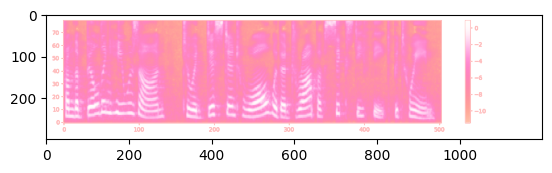

In [ ]:
from utils import plot_tensor, save_plot
import matplotlib.pyplot as plt

data = plot_tensor(truc[1])
plt.imshow(data)

In [ ]:
batch = collator([dataset_obj[i] for i in range(4)])

In [ ]:
valid_batch = dataset_obj.sample_test_batch(size=4)

In [ ]:
from metrics import normalized_dtw_score

with torch.no_grad():
    for i, item in enumerate(valid_batch[:1]):
        x = item["x"].to(torch.long).unsqueeze(0)
        x_lengths = torch.LongTensor([x.shape[-1]])
        
        y_enc, y_dec, attn = model(x, x_lengths, n_timesteps=50)

        y_gt = item["y"].T.cpu().numpy()  # (n_frames, n_feats)
        y_enc_ = y_enc[0, :, :].T.cpu()
        y_dec_ = y_dec[0, :, :].T.cpu()
        print(y_enc_.shape, y_dec_.shape, y_gt.shape)

torch.Size([370, 80]) torch.Size([370, 80]) (759, 80)


In [ ]:
dist_gt_enc, y_gt_enc_ada, y_enc_ada = normalized_dtw_score(
            y_gt[:,::1], y_enc_.numpy()[:,::1]
        )
dist_gt_dec, y_gt_dec_ada, y_dec__ada = normalized_dtw_score(
    y_gt[:,::1], y_dec_.numpy()[:,::1]
)

# v3

In [ ]:
import numpy as np
import torch
from pathlib import Path

from configs import params_v3
from data_phnmmel import (
    PhnmMelDataset,
    PhnmMelBatchCollate,
)
from model import ArtTTS
from torch.utils.data import DataLoader

from paths import DATA_DIR

In [ ]:
device='cpu'

model = ArtTTS(
        params_v3.n_ipa_feats,
        params_v3.n_spks,
        None,
        params_v3.n_enc_channels,
        params_v3.filter_channels,
        params_v3.filter_channels_dp,
        params_v3.n_heads,
        params_v3.n_enc_layers,
        params_v3.enc_kernel,
        params_v3.enc_dropout,
        params_v3.window_size,
        params_v3.n_feats,
        params_v3.dec_dim,
        params_v3.beta_min,
        params_v3.beta_max,
        params_v3.pe_scale,
    ).to(device)

dataset_obj = PhnmMelDataset(
        params_v3.train_filelist_path,
        data_root_dir=DATA_DIR,
        n_fft=params_v3.n_fft,
        n_mels=params_v3.n_feats,
        sample_rate=params_v3.sample_rate,
        hop_length=params_v3.hop_length,
        win_length=params_v3.win_length,
        f_min=params_v3.f_min,
        f_max=params_v3.f_max,
        random_seed=params_v3.random_seed,
    )

filepaths_list = dataset_obj.filepaths_list
collator = PhnmMelBatchCollate()

In [ ]:
truc = dataset_obj.get_pair(
    filepaths_list[0],
)

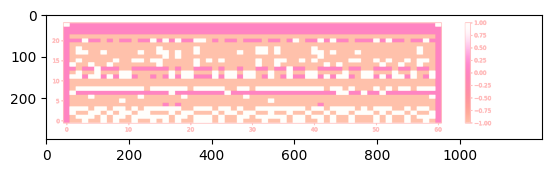

In [ ]:
from utils import plot_tensor, save_plot
import matplotlib.pyplot as plt

data = plot_tensor(truc[0])
plt.imshow(data)

In [ ]:
valid_batch = dataset_obj.sample_test_batch(size=4)

In [ ]:
from metrics import normalized_dtw_score

with torch.no_grad():
    for i, item in enumerate(valid_batch[:1]):
        x = item["x"].to(torch.float32).unsqueeze(0)
        x_lengths = torch.LongTensor([x.shape[-1]])
        y_enc, y_dec, attn = model(x, x_lengths, n_timesteps=50)

        y_gt = item["y"].T.cpu().numpy()  # (n_frames, n_feats)
        y_enc_ = y_enc[0, :, :].T.cpu()
        y_dec_ = y_dec[0, :, :].T.cpu()
        print(y_enc_.shape, y_dec_.shape, y_gt.shape)

/home/anli/Desktop/art-tts/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


torch.Size([51, 80]) torch.Size([51, 80]) (268, 80)


In [ ]:
dist_gt_enc, y_gt_enc_ada, y_enc_ada = normalized_dtw_score(
            y_gt[:,::1], y_enc_.numpy()[:,::1]
        )
dist_gt_dec, y_gt_dec_ada, y_dec__ada = normalized_dtw_score(
    y_gt[:,::1], y_dec_.numpy()[:,::1]
)
print(dist_gt_enc, dist_gt_dec)

49.65833395388807 856.9065772568385


In [ ]:
valid_batch

[{'y': tensor([[-5.9361, -6.7815, -7.3117,  ..., -9.1152, -9.3158, -8.4808],
          [-6.4368, -6.0642, -6.3291,  ..., -8.3781, -8.0945, -7.9244],
          [-6.4485, -5.2184, -4.8523,  ..., -7.9644, -7.1799, -7.2195],
          ...,
          [-8.2699, -9.1744, -8.9128,  ..., -9.4575, -9.3027, -9.4068],
          [-7.4382, -8.2976, -8.8284,  ..., -9.4863, -9.2278, -9.2496],
          [-8.4395, -8.8216, -8.8271,  ..., -9.3338, -9.5841, -9.4296]]),
  'x': tensor([[ 0., -1.,  1.,  ...,  1.,  1.,  0.],
          [ 0., -1.,  1.,  ...,  1.,  1.,  0.],
          [ 0.,  1., -1.,  ..., -1., -1.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 1.,  0.,  0.,  ...,  0.,  0.,  1.]])},
 {'y': tensor([[-7.3691, -6.4887, -5.5243,  ..., -8.4941, -8.2855, -7.6720],
          [-7.5116, -6.2125, -4.9933,  ..., -6.9080, -6.5364, -6.6208],
          [-7.0461, -5.4327, -4.0540,  ..., -5.0537, -5.2602, -6.1054],
          ...,

In [ ]:
valid_batch[0]["x"].dtype

torch.float32

In [ ]:
with torch.no_grad():
    for i, item in enumerate(valid_batch[:1]):
        x = item["x"].to(torch.float32).unsqueeze(0)
        x_lengths = torch.LongTensor([x.shape[-1]])
        y_enc, y_dec, attn = model(x, x_lengths, n_timesteps=50)

        y_gt = item["y"].T.cpu().numpy()  # (n_frames, n_feats)
        y_enc_ = y_enc[0, :, :].T.cpu()  # (n_frames, n_feats)
        y_dec_ = y_dec[0, :, :].T.cpu()  # (n_frames, n_feats)

        # Compute DTW distance to targets
        dist_gt_enc, y_gt_enc_ada, y_enc_ada = normalized_dtw_score(
            y_gt, y_enc_.numpy()
        )
        dist_gt_dec, y_gt_dec_ada, y_dec_ada = normalized_dtw_score(
            y_gt, y_dec_.numpy()
        )

# v1

In [ ]:
from data_phnm import PhnmArticDataset, PhnmArticBatchCollate
from configs import params_v1_1
from torch.utils.data import DataLoader
from paths import DATA_DIR, CKPT_DIR, ENCODED_AUDIO_EN_DIR
from balance_batch import get_length_grouped_indices, LengthGroupedSampler

train_dataset = PhnmArticDataset(
        params_v1_1.train_filelist_path,
        data_root_dir=DATA_DIR,
        reorder_feats=params_v1_1.reorder_feats,
        pitch_idx=params_v1_1.pitch_idx,
        loudness_idx=params_v1_1.loudness_idx,
        log_normalize_loudness=params_v1_1.log_normalize_loudness,
        merge_diphtongues=params_v1_1.merge_diphtongues,
        load_coder=False,
        sparc_ckpt_path=params_v1_1.sparc_ckpt_path,
        shuffle=params_v1_1.shuffle,  # do not shuffle for compatibility custom sampler
        random_seed=params_v1_1.random_seed,
    )

/home/anli/Desktop/art-tts/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from tqdm import tqdm

train_lengths = []
for i in tqdm(range(len(train_dataset.filepaths_list))):
    length = train_dataset.get_phnm_emb(phnm3_fp=train_dataset.filepaths_list[i][1]).shape[1]
    train_lengths.append(length)

100%|██████████| 9892/9892 [00:40<00:00, 245.43it/s]


In [ ]:
import torch

ind = get_length_grouped_indices(train_lengths, batch_size=params_v1_1.batch_size, generator=torch.manual_seed(params_v1_1.random_seed))

In [ ]:
train_sampler = LengthGroupedSampler(batch_size=params_v1_1.batch_size,
                        lengths=train_lengths,
                        generator=torch.manual_seed(params_v1_1.random_seed),
                        )

# v6

In [ ]:
from data_ms import PhnmArticDataset, PhnmArticBatchCollate
from configs import params_v6
from torch.utils.data import DataLoader
from paths import DATA_DIR
from voxcommunis.sampler import LengthGroupedSampler, LengthGroupedLanguageUpSampler
from voxcommunis.decoder import FeatureDecoder
from voxcommunis.data import FeatureTokenizer

import torch

fd = FeatureDecoder(sum_diphthong=True)
tokenizer = FeatureTokenizer(fd)

split = "train-20h"
dataset_dir = DATA_DIR / "VoxCommunis"
split_dir = dataset_dir / split

In [ ]:
separate_files = False
manifests_dir = split_dir / "manifests"
alignments_dir = split_dir / "alignments"
manifest_path = manifests_dir / "it.tsv"
alignments_path = alignments_dir / "it.align"

train_dataset = PhnmArticDataset(
        dataset_dir=dataset_dir,
        separate_files=separate_files,
        manifest_path= manifest_path,
        alignment_path= alignments_path,
        feature_tokenizer=tokenizer,
        reorder_feats=params_v6.reorder_feats,
        pitch_idx=params_v6.pitch_idx,
        loudness_idx=params_v6.loudness_idx,
        log_normalize_loudness=params_v6.log_normalize_loudness,
        random_seed=params_v6.random_seed,
    )
train_lengths = [train_dataset.manifest[i][1][1] for i in range(len(train_dataset))]
train_sampler = LengthGroupedSampler(batch_size=params_v6.batch_size,
                        lengths=train_lengths,
                        generator=torch.manual_seed(params_v6.random_seed),
                        )
train_loader = DataLoader(
        train_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=PhnmArticBatchCollate(),
        sampler=train_sampler,
        num_workers=3,
)

In [ ]:
from model_ms import GradTTArtic

device = 'cpu'
model = GradTTArtic(
        n_ipa_feats=params_v6.n_ipa_feats,    #26, 24 phonological traits + 1 silence dim + 1 phoneme repetition count
        spk_emb_dim=params_v6.spk_emb_dim, # 64
        n_enc_channels=params_v6.n_enc_channels, # 192
        filter_channels=params_v6.filter_channels,    # 768
        filter_channels_dp=params_v6.filter_channels_dp, # 256
        n_heads=params_v6.n_heads,    # 2
        n_enc_layers=params_v6.n_enc_layers,   # 6
        enc_kernel=params_v6.enc_kernel,     # 3
        enc_dropout=params_v6.enc_dropout,    # 0.1
        window_size=params_v6.window_size,    # 4
        n_feats=params_v6.n_feats,    # 16 (articulatory features)
        dec_dim=params_v6.dec_dim,    # 64
        beta_min=params_v6.beta_min,   # 0.05
        beta_max=params_v6.beta_max,   # 20.0
        pe_scale=params_v6.pe_scale,   # 1000
        spk_preemb_dim=1024, # Similar 
    ).to(device)

In [ ]:
batch = next(iter(train_loader))
x = batch["x"].to(device)
x_lengths = torch.LongTensor(batch["x_lengths"])
y = batch["y"].to(device)
y_lengths = torch.LongTensor(batch["y_lengths"])
spk_ft = batch["spk_ft"].to(device)

In [ ]:
item = train_dataset[0]

x = item["x"].to(torch.float32).unsqueeze(0)
x_lengths = torch.LongTensor([x.shape[-1]])
spk_ft = item["spk_ft"].unsqueeze(0).to(torch.float32)

In [ ]:
enc, dec, attn = model(x, x_lengths, spk_ft, n_timesteps=1)

In [ ]:
enc.shape, dec.shape, attn.shape

(torch.Size([1, 16, 101]),
 torch.Size([1, 16, 101]),
 torch.Size([1, 1, 13, 104]))

In [ ]:
batch = next(iter(train_loader))
x = batch["x"].to(device)
x_lengths = torch.LongTensor(batch["x_lengths"])
y = batch["y"].to(device)
y_lengths = torch.LongTensor(batch["y_lengths"])
spk_ft = batch["spk_ft"].to(device)

In [ ]:
prior_loss, diff_loss = model.compute_loss(x, x_lengths, y, y_lengths, spk_ft, out_size=params_v6.out_size)

In [ ]:
prior_loss, diff_loss

(tensor(1.5281, grad_fn=<DivBackward0>),
 tensor(1.0510, grad_fn=<DivBackward0>))

# msml

In [1]:
from data_ms import PhnmArticDataset, PhnmArticBatchCollate, PhnmDataset, PhnmBatchCollate
from configs import params_msml1h
from torch.utils.data import DataLoader
from paths import DATA_DIR
from voxcommunis.sampler import LengthGroupedLanguageUpSampler
from voxcommunis.decoder import FeatureDecoder
from voxcommunis.data import FeatureTokenizer

import torch

fd = FeatureDecoder(sum_diphthong=True)
tokenizer = FeatureTokenizer(fd)

split = "train-1h"
dataset_dir = DATA_DIR / "VoxCommunis"
split_dir = dataset_dir / split

In [ ]:
separate_files = True
manifests_dir = split_dir / "manifests"
alignments_dir = split_dir / "alignments"

train_dataset = PhnmDataset(
        dataset_dir=dataset_dir,
        separate_files=separate_files,
        manifest_path= manifests_dir,
        alignment_path= alignments_dir,
        feature_tokenizer=tokenizer,
        reorder_feats=params_msml1h.reorder_feats,
        pitch_idx=params_msml1h.pitch_idx,
        loudness_idx=params_msml1h.loudness_idx,
        log_normalize_loudness=params_msml1h.log_normalize_loudness,
        random_seed=params_msml1h.random_seed,
        exclude_langs=params_msml1h.exclude_langs # Exclude English for this 1h experiment
    )
train_lengths = [train_dataset.manifest[i][1][1] for i in range(len(train_dataset))]
train_sampler = LengthGroupedLanguageUpSampler(
    batch_size=params_msml1h.batch_size,
    lengths=train_lengths,
    lang_sizes=train_dataset.lang_sizes,
    generator=torch.manual_seed(params_msml1h.random_seed),
    upsample_factor=1,    
)
train_loader = DataLoader(
        train_dataset,
        batch_size=params_msml1h.batch_size,
        shuffle=False,
        collate_fn=PhnmBatchCollate(),
        sampler=train_sampler,
        num_workers=3,
)